In [1]:
import numpy as np
import time
import os
import cv2
import sys

In [2]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

In [4]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X_c, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X_c, length_per_mvi)

print("Total time to load small-data is", time.time() - start_time, "seconds")

  0%|          | 2/10421 [00:00<10:35, 16.38it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [02:35<00:00, 73.30it/s]
1it [00:00,  2.82it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.93it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:00,  3.61it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  3.43it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  2.99it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:01,  3.03it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  3.01it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


10it [00:02,  3.41it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821
MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.53it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:03,  2.74it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.31it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small-data is 160.3046154975891 seconds


In [5]:
# Divide the data into train, test

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

Xc_train, Xc_test, Y_train_dict, Y_test_dict = _split_train_test(X_c, Y_dict)

In [6]:
# Now cluster the data

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


(540, 960, 3)
(540, 960, 3)


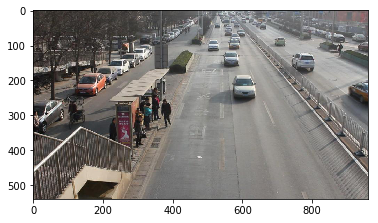

In [7]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(Xc_train[image_index].shape)

example = Xc_train[image_index]
print(example.shape)

plt.imshow(example)

In [16]:
# Must perform normalization for the autoencoder to perform well
Xc_train_norm = np.copy(Xc_train)
Xc_test_norm = np.copy(Xc_test)


def _reform_input(image_table, grayscale = True):
    # This function could rapidly change according to what we want
    # But the purpose of this function is to feed in the input as per network specifications
    # current specs: convert to size (48, 80) and grayscale
    height = 48
    width = 80
    start_time = time.time()
    assert(len(image_table.shape) == 4)
    n_samples = image_table.shape[0]
    channels = 3
    if grayscale:
        channels = 1
    
    image_array = np.ndarray(shape=(n_samples, height, width, channels))
        
    for i in range(len(image_table)):
        image = image_table[i ,: ,: ,:]
        if grayscale:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
        image = cv2.resize(image, (width, height))
        # might need to expand dimension
        if grayscale:
            image_array[i ,: ,: ,0] = image
        else:
            image_array[i,:,:,:] = image
        
    image_array /= 255.0  # normalize the input for layers
    print("finished reforming input, total time taken is", time.time() - start_time, "seconds")
    return image_array



Xb_train_norm = _reform_input(Xc_train_norm, grayscale = True)
Xb_test_norm = _reform_input(Xc_test_norm, grayscale = True)
Xc_train_norm = _reform_input(Xc_train_norm, grayscale = False)
Xc_test_norm = _reform_input(Xc_test_norm, grayscale = False)



finished reforming input, total time taken is 37.84143590927124 seconds
finished reforming input, total time taken is 0.9838628768920898 seconds
finished reforming input, total time taken is 2.1862270832061768 seconds
finished reforming input, total time taken is 0.3488466739654541 seconds


In [17]:

keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [18]:
n_samples1, width1, height1, channels1 = Xb_train_norm.shape
n_samples2, width2, height2, channels2 = Xb_test_norm.shape

assert(width1 == width2)
assert(height1 == height2)
assert(channels1 == channels2)


n_samples1, width1, height1, channels1 = Xc_train_norm.shape
n_samples2, width2, height2, channels2 = Xc_test_norm.shape

assert(width1 == width2)
assert(height1 == height2)
assert(channels1 == channels2)


In [20]:
# Combined network with both FC and CNN layers


# Input
def build(X_train):
    n_samples, width, height, channels = X_train.shape
    
    input_img = Input(shape=(width, height, channels))
    # Encoder
    x = Conv2D(8,(3,3),
               activation='relu',
               padding='same')(input_img)
    x = Conv2D(8,(3,3),
               activation='relu',
               padding='same')(x)
    x = MaxPooling2D((2,2),
                     padding='same')(x) 
    x = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x)
    x = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x)
    x = MaxPooling2D((2,2),
                     padding='same')(x) # Size 
    x = Flatten()(x)
    encoded = Dense(256)(x)
    # Decoder
    x = Dense(int(width / 4 * height / 4 * 16))(encoded)
    x = Reshape((12, 20, 16))(x)
    x = UpSampling2D((2, 2))(x) # 24, 40, 16
    x = Conv2D(16, (3, 3),
               activation='relu',
               padding='same')(x)
    x = Conv2D(16, (3, 3),
               activation='relu',
               padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Size 48, 80, 16
    x = Conv2D(8, (3, 3),
               activation='relu',
               padding='same')(x)
    decoded = Conv2D(channels, (3, 3),
               activation='relu',
               padding='same')(x)




    autoencoder = Model(input_img, decoded)

    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.summary()
    return encoder, autoencoder

b_encoder, b_autoencoder = build(Xb_train_norm)
c_encoder, c_autoencoder = build(Xc_train_norm)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 80, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 80, 8)         80        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 80, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 40, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 40, 16)        1168      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 20, 16)        0         
__________

In [21]:
start_time = time.time()
train_history = b_autoencoder.fit(Xb_train_norm, Xb_train_norm, epochs=200, batch_size=2048, validation_data=(Xb_test_norm, Xb_test_norm))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")



Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 7s 846us/step - loss: 0.2127 - val_loss: 0.1120
Epoch 2/200
8336/8336 [==============================] - 2s 215us/step - loss: 0.0621 - val_loss: 0.0470
Epoch 3/200
8336/8336 [==============================] - 2s 205us/step - loss: 0.0391 - val_loss: 0.0309
Epoch 4/200
8336/8336 [==============================] - 2s 220us/step - loss: 0.0291 - val_loss: 0.0273
Epoch 5/200
8336/8336 [==============================] - 2s 245us/step - loss: 0.0269 - val_loss: 0.0243
Epoch 6/200
8336/8336 [==============================] - 2s 218us/step - loss: 0.0245 - val_loss: 0.0236
Epoch 7/200
8336/8336 [==============================] - 2s 207us/step - loss: 0.0236 - val_loss: 0.0233
Epoch 8/200
8336/8336 [==============================] - 2s 197us/step - loss: 0.0228 - val_loss: 0.0233
Epoch 9/200
8336/8336 [==============================] - 2s 193us/step - loss: 0.0223 - val_loss: 0.0224
Epoch 1

Epoch 78/200
8336/8336 [==============================] - 2s 223us/step - loss: 0.0092 - val_loss: 0.0139
Epoch 79/200
8336/8336 [==============================] - 2s 211us/step - loss: 0.0092 - val_loss: 0.0138
Epoch 80/200
8336/8336 [==============================] - 2s 222us/step - loss: 0.0095 - val_loss: 0.0149
Epoch 81/200
8336/8336 [==============================] - 2s 218us/step - loss: 0.0096 - val_loss: 0.0143
Epoch 82/200
8336/8336 [==============================] - 2s 228us/step - loss: 0.0096 - val_loss: 0.0139
Epoch 83/200
8336/8336 [==============================] - 2s 221us/step - loss: 0.0093 - val_loss: 0.0144
Epoch 84/200
8336/8336 [==============================] - 2s 225us/step - loss: 0.0092 - val_loss: 0.0138
Epoch 85/200
8336/8336 [==============================] - 2s 223us/step - loss: 0.0091 - val_loss: 0.0142
Epoch 86/200
8336/8336 [==============================] - 2s 231us/step - loss: 0.0090 - val_loss: 0.0136
Epoch 87/200
8336/8336 [======================

Epoch 155/200
8336/8336 [==============================] - 2s 203us/step - loss: 0.0070 - val_loss: 0.0128
Epoch 156/200
8336/8336 [==============================] - 2s 205us/step - loss: 0.0070 - val_loss: 0.0129
Epoch 157/200
8336/8336 [==============================] - 2s 204us/step - loss: 0.0070 - val_loss: 0.0130
Epoch 158/200
8336/8336 [==============================] - 2s 207us/step - loss: 0.0069 - val_loss: 0.0128
Epoch 159/200
8336/8336 [==============================] - 2s 205us/step - loss: 0.0069 - val_loss: 0.0128
Epoch 160/200
8336/8336 [==============================] - 2s 206us/step - loss: 0.0069 - val_loss: 0.0130
Epoch 161/200
8336/8336 [==============================] - 2s 211us/step - loss: 0.0069 - val_loss: 0.0126
Epoch 162/200
8336/8336 [==============================] - 2s 208us/step - loss: 0.0071 - val_loss: 0.0134
Epoch 163/200
8336/8336 [==============================] - 2s 204us/step - loss: 0.0069 - val_loss: 0.0131
Epoch 164/200
8336/8336 [============

In [22]:
start_time = time.time()
train_history = c_autoencoder.fit(Xc_train_norm, Xc_train_norm, epochs=200, batch_size=2048, validation_data=(Xc_test_norm, Xc_test_norm))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")


Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 6s 684us/step - loss: 0.2107 - val_loss: 0.1369
Epoch 2/200
8336/8336 [==============================] - 4s 497us/step - loss: 0.1246 - val_loss: 0.0839
Epoch 3/200
8336/8336 [==============================] - 4s 434us/step - loss: 0.0633 - val_loss: 0.0418
Epoch 4/200
8336/8336 [==============================] - 4s 477us/step - loss: 0.0385 - val_loss: 0.0300
Epoch 5/200
8336/8336 [==============================] - 4s 472us/step - loss: 0.0285 - val_loss: 0.0279
Epoch 6/200
8336/8336 [==============================] - 4s 428us/step - loss: 0.0270 - val_loss: 0.0258
Epoch 7/200
8336/8336 [==============================] - 4s 440us/step - loss: 0.0251 - val_loss: 0.0248
Epoch 8/200
8336/8336 [==============================] - 4s 450us/step - loss: 0.0243 - val_loss: 0.0240
Epoch 9/200
8336/8336 [==============================] - 4s 422us/step - loss: 0.0234 - val_loss: 0.0233
Epoch 1

Epoch 78/200
8336/8336 [==============================] - 4s 422us/step - loss: 0.0094 - val_loss: 0.0132
Epoch 79/200
8336/8336 [==============================] - 3s 420us/step - loss: 0.0093 - val_loss: 0.0132
Epoch 80/200
8336/8336 [==============================] - 3s 417us/step - loss: 0.0092 - val_loss: 0.0133
Epoch 81/200
8336/8336 [==============================] - 4s 422us/step - loss: 0.0092 - val_loss: 0.0131
Epoch 82/200
8336/8336 [==============================] - 4s 437us/step - loss: 0.0093 - val_loss: 0.0147
Epoch 83/200
8336/8336 [==============================] - 4s 444us/step - loss: 0.0096 - val_loss: 0.0133
Epoch 84/200
8336/8336 [==============================] - 4s 422us/step - loss: 0.0092 - val_loss: 0.0133
Epoch 85/200
8336/8336 [==============================] - 4s 426us/step - loss: 0.0091 - val_loss: 0.0134
Epoch 86/200
8336/8336 [==============================] - 3s 419us/step - loss: 0.0090 - val_loss: 0.0132
Epoch 87/200
8336/8336 [======================

Epoch 155/200
8336/8336 [==============================] - 4s 453us/step - loss: 0.0073 - val_loss: 0.0127
Epoch 156/200
8336/8336 [==============================] - 4s 428us/step - loss: 0.0074 - val_loss: 0.0127
Epoch 157/200
8336/8336 [==============================] - 4s 434us/step - loss: 0.0077 - val_loss: 0.0127
Epoch 158/200
8336/8336 [==============================] - 3s 419us/step - loss: 0.0075 - val_loss: 0.0128
Epoch 159/200
8336/8336 [==============================] - 4s 427us/step - loss: 0.0074 - val_loss: 0.0131
Epoch 160/200
8336/8336 [==============================] - 4s 437us/step - loss: 0.0073 - val_loss: 0.0127
Epoch 161/200
8336/8336 [==============================] - 4s 436us/step - loss: 0.0073 - val_loss: 0.0127
Epoch 162/200
8336/8336 [==============================] - 4s 425us/step - loss: 0.0072 - val_loss: 0.0127
Epoch 163/200
8336/8336 [==============================] - 4s 427us/step - loss: 0.0072 - val_loss: 0.0126
Epoch 164/200
8336/8336 [============

In [23]:
# After downsizing the images, we need to cluster them by similarity
# Heuristic we will use is to assume fps rate is 20. We will make num_samples / 20 clusters

# Apply hierarchical clustering
# Remember the indexes
# Put the images into correct locations
# TODO: Currently the images are not being divided correctly... We need to find out why

from sklearn.cluster import AgglomerativeClustering

#image_table_flattened = image_table.reshape(-1, width*height).astype('float32')
#image_table /= 255.0
def cluster(X_train_norm, X_test_norm, encoder):
    
    X_train_compressed = encoder.predict(X_train_norm)
    X_test_compressed = encoder.predict(X_test_norm)
    
    fps = 20
    ac = AgglomerativeClustering(n_clusters=len(X_train_compressed) // fps)
    ac1 = AgglomerativeClustering(n_clusters=len(X_test_compressed) // fps)

    start_time = time.time()
    ac.fit(X_train_compressed)
    print("Time to fit X_train", time.time() - start_time)
    X_train_clusters = ac.labels_

    start_time = time.time()
    ac1.fit(X_test_compressed)
    print("Time to fit X_test", time.time() - start_time)
    X_test_clusters = ac1.labels_


    print(min(X_train_clusters))
    print(max(X_train_clusters))
    print(min(X_test_clusters))
    print(max(X_test_clusters))

    return X_train_clusters, X_test_clusters

Xb_train_clusters, Xb_test_clusters = cluster(Xb_train_norm, Xb_test_norm, b_encoder)
Xc_train_clusters, Xc_test_clusters = cluster(Xc_train_norm, Xc_test_norm, c_encoder)


Time to fit X_train 6.3519675731658936
Time to fit X_test 0.41694140434265137
0
415
0
103
Time to fit X_train 6.084600448608398
Time to fit X_test 0.3123464584350586
0
415
0
103


In [26]:
# Choose representative frames from each cluster
# Create a fake X_train, Y_train, X_val, Y_val for retraining the filters

# We have X_train, X_train_clusters (this gives cluster numbers), Y_train, Y_names
def pick_frames(X_train, X_test, X_train_clusters, X_test_clusters, Y_train_dict, Y_test_dict, grayscale = True):
    visited_cluster_nums = set()

    n_samples, width1, height1, _ = X_train.shape
    n_samples, width2, height2, _ = X_test.shape
    if grayscale:
        X_train_rep = np.zeros(shape = (max(X_train_clusters)+1, width1, height1, 1))
        X_test_rep = np.zeros(shape = (max(X_test_clusters)+1, width2, height2, 1))
    else:
        X_train_rep = np.zeros(shape = (max(X_train_clusters)+1, width1, height1, 3))
        X_test_rep = np.zeros(shape = (max(X_test_clusters)+1, width2, height2, 3))
    Y_train_dict_rep = {}
    Y_test_dict_rep = {}
    #Y_test_rep = np.zeros(shape = (max(X_test_clusters)+1, len(Y_names)))

    import copy
    categories = ['vehicle_type', 'color', 'speed', 'intersection']
    for category in categories:
        Y_train_dict_rep[category] = [None] * (max(X_train_clusters)+1)
        Y_test_dict_rep[category] = [None] * (max(X_test_clusters) + 1)
        
    assert(len(X_train_clusters) == len(X_train))
    assert(len(X_test_clusters) == len(X_test))
    
    for i in range(len(X_train_clusters)):
        if X_train_clusters[i] not in visited_cluster_nums:
            visited_cluster_nums.add(X_train_clusters[i])
            # we want to pick these frames out but we need to remember their index so that we can extract their labels
            # cluster number will be their index
            assert(len(X_train.shape) == 4)
            if grayscale:
                X_train_rep[X_train_clusters[i],:,:,:] = X_train[i,:,:,:]
            for category in categories:
                Y_train_dict_rep[category][X_train_clusters[i]] = copy.deepcopy(Y_train_dict[category][i])

    visited_cluster_nums.clear()

    for i in range(len(X_test_clusters)):
        if X_test_clusters[i] not in visited_cluster_nums:
            visited_cluster_nums.add(X_test_clusters[i])
            # we want to pick these frames out but we need to remember their index so that we can extract their labels
            # cluster number will be their index
            assert(len(X_test.shape) == 4)
            X_test_rep[X_test_clusters[i],:,:,:] = X_test[i,:,:,:]
            for category in categories:
                Y_test_dict_rep[category][X_test_clusters[i]] = copy.deepcopy(Y_test_dict[category][i])


    print(X_train_rep.shape)
    print(X_test_rep.shape)
    
    return X_train_rep, X_test_rep, Y_train_dict_rep, Y_test_dict_rep


Xb_train_rep, Xb_test_rep, Yb_train_dict_rep, Yb_test_dict_rep = pick_frames(Xb_train_norm, Xb_test_norm, Xb_train_clusters, Xb_test_clusters, Y_train_dict, Y_test_dict, grayscale = True)
Xc_train_rep, Xc_test_rep, Yc_train_dict_rep, Yc_test_dict_rep = pick_frames(Xc_train_norm, Xc_test_norm, Xc_train_clusters, Xc_test_clusters, Y_train_dict, Y_test_dict, grayscale = False)


(416, 48, 80, 1)
(104, 48, 80, 1)
(416, 48, 80, 3)
(104, 48, 80, 3)


In [28]:
# Train the filters
from filters.pp import PP

def train_rep_filters(X_train_rep, Y_train_dict_rep):
    pp_rep = PP()
    start_time = time.time()
    pp_rep.train(X_train_rep, Y_train_dict_rep)
    print("Total time to train all columns all models ", time.time() - start_time, "seconds")
    return pp_rep

ppb_rep = train_rep_filters(Xb_train_rep, Yb_train_dict_rep)
ppc_rep = train_rep_filters(Xc_train_rep, Yc_train_dict_rep)

Generating binary labels...
(416, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Done in 0.07683014869689941 seconds
reshaping images...
before: (416, 48, 80, 1)
After cha

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

rf finished training for column t=others in 0.008769989013671875 seconds
rf finished training for column c=red in 0.008214950561523438 seconds
rf finished training for column c=white in 0.00774383544921875 seconds
rf finished training for column c=black in 0.008225679397583008 seconds
rf finished training for column c=silver in 0.007699251174926758 seconds
rf finished training for column s>40 in 0.008072376251220703 seconds
rf finished training for column s>50 in 0.007719755172729492 seconds
rf finished training for column s>60 in 0.00771021842956543 seconds
rf finished training for column s<65 in 0.007058858871459961 seconds
rf finished training for column s<70 in 0.007544040679931641 seconds
rf finished training for column i=pt335 in 0.008273124694824219 seconds
rf finished training for column i=pt211 in 0.008146524429321289 seconds
rf finished training for column i=pt342 in 0.008144855499267578 seconds
rf finished training for column i=pt208 in 0.007798671722412109 seconds
rf finish

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/decomposition/pca.py:446: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time it took to train pca: 0.11713933944702148 seconds
X_train shape:  (332, 180)
X_train_pca shape:  (332, 9)
Done in 0.11731481552124023 seconds
Starting processing...
Full Model Name: pca_svm using pca'd X_train
All the labels are same for column t=car
Training for t=van
svm finished training for column t=van in 0.008744239807128906 seconds
Training for t=bus
svm finished training for column t=bus in 0.010980367660522461 seconds
Training for t=others
svm finished training for column t=others in 0.003345489501953125 seconds
Training for c=red
svm finished training for column c=red in 0.0034966468811035156 seconds
Training for c=white
svm finished training for column c=white in 0.00327301025390625 seconds
Training for c=black
svm finished training for column c=black in 0.003642559051513672 seconds
Training for c=silver
svm finished training for column c=silver in 0.0030994415283203125 seconds
Training for s>40
svm finished training for column s>40 in 0.012650728225708008 seconds
Train

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

In [31]:
# Before Evaluation, we want to convert to the original test with labels with the chosen ones
# Use X_test, Y_test_adjusted for evaluation
Y_names, Y_test = ppb_rep._generate_binary_labels(Y_test_dict, len(Xc_test))
_, Yb_test_rep = ppb_rep._generate_binary_labels(Yb_test_dict_rep, len(Xc_test))
_, Yc_test_rep = ppb_rep._generate_binary_labels(Yc_test_dict_rep, len(Xc_test))

def extend_labels(Y_test, Y_test_rep, X_test_clusters):
    n_samples, columns = Y_test.shape
    Y_test_adjusted = np.zeros(shape = (n_samples, columns))
    for i in range(len(X_test_clusters)):
        Y_test_adjusted[i,:] = Y_test_rep[X_test_clusters[i],:]
    return Y_test_adjusted

Yb_test_adjusted = extend_labels(Y_test, Yb_test_rep, Xb_test_clusters)

Yc_test_adjusted = extend_labels(Y_test, Yc_test_rep, Xc_test_clusters)


(2085, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(2085, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60',

In [34]:
# Evaluate the filters
def evaluate(pp_rep, X_test, Y_names, Y_test_adjusted):
    pca_model_rep = pp_rep.trained_pre['pca']
    trained_models_rep = pp_rep.trained_post 
    tic = time.time()
    """
    {'t=car': {'pca_svm': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=10000, probability=True, random_state=None,
      shrinking=True, tol=0.001, verbose=False),
    """
    X_test_reshaped = pp_rep._reshape_image(X_test)
    X_test_pcaed = pca_model_rep.transform(X_test_reshaped)


    stats_rep = {}
    for Y_col, models in trained_models_rep.items():
        for model_name, model in models.items():
            if 'pca' in model_name:
                index = Y_names.index(Y_col)
                #print("index is",index)
                #print(Y_test[:10][0])
                #print(type(index))
                score = model.score(X_test_pcaed, Y_test_adjusted[:, index])
                stats_rep[Y_col + " " + model_name] = [score]
            else:
                index = Y_names.index(Y_col)
                score = model.score(X_test_reshaped, Y_test_adjusted[:, index])
                stats_rep[Y_col + " " + model_name] = [score]

    print("Finished evaluation in ", time.time() - tic, "seconds")
    
    return stats_rep

b_stats_rep = evaluate(ppb_rep, Xb_test_norm, Y_names, Yb_test_adjusted)
c_stats_rep = evaluate(ppc_rep, Xc_test_norm, Y_names, Yc_test_adjusted)


before: (2085, 48, 80, 1)
After change, shape of image is (2085, 60)
Finished evaluation in  0.295102596282959 seconds
before: (2085, 48, 80, 3)
After change, shape of image is (2085, 180)
Finished evaluation in  0.21940875053405762 seconds


In [35]:
print(b_stats_rep)

{'t=van pca_svm': [0.6354916067146283], 't=van dnn': [0.6354916067146283], 't=van pca_rf': [0.6345323741007194], 't=bus pca_svm': [0.6863309352517986], 't=bus dnn': [0.7448441247002399], 't=bus pca_rf': [0.6810551558752997], 't=others pca_svm': [0.9304556354916067], 't=others dnn': [0.9237410071942446], 't=others pca_rf': [0.9314148681055155], 'c=red pca_svm': [0.99568345323741], 'c=red dnn': [0.99568345323741], 'c=red pca_rf': [0.99568345323741], 'c=white pca_svm': [0.9769784172661871], 'c=white dnn': [0.9769784172661871], 'c=white pca_rf': [0.9769784172661871], 'c=black pca_svm': [0.9918465227817745], 'c=black dnn': [0.9918465227817745], 'c=black pca_rf': [0.9918465227817745], 'c=silver pca_svm': [1.0], 'c=silver dnn': [1.0], 'c=silver pca_rf': [0.9995203836930455], 's>40 pca_svm': [0.7630695443645084], 's>40 dnn': [0.7007194244604317], 's>40 pca_rf': [0.7726618705035971], 's>50 pca_svm': [0.8839328537170263], 's>50 dnn': [0.6479616306954437], 's>50 pca_rf': [0.8810551558752998], 's>

In [42]:
# Compute the accuracy and speed

# convert stats dict to table
# rows should be column name and model
# cols should be accuracy, training_time
def convert2arr(stats_rep, pp_rep):
    stats_arr_rep = np.zeros(shape=(len(stats_rep), 2))
    row_names_rep = []
    index = 0
    for row, col in stats_rep.items():
        row_names_rep.append(row)
        stats_arr_rep[index, 0] = col[0]
        index += 1

    for Y_col, models in pp_rep.column_stats.items():
        for model_name, cost in models.items():
            row_index = row_names_rep.index(Y_col + " " + model_name)
            stats_arr_rep[row_index, 1] = cost[0]
    return stats_arr_rep, row_names_rep

b_stats_arr_rep, b_row_names = convert2arr(b_stats_rep, ppb_rep)
c_stats_arr_rep, c_row_names = convert2arr(c_stats_rep, ppc_rep)

In [38]:
print(b_stats_arr_rep)

[[0.63549161 0.19      ]
 [0.63549161 0.        ]
 [0.63453237 0.18      ]
 [0.68633094 0.18      ]
 [0.74484412 0.11      ]
 [0.68105516 0.18      ]
 [0.93045564 0.18      ]
 [0.92374101 0.04      ]
 [0.93141487 0.18      ]
 [0.99568345 0.17      ]
 [0.99568345 0.01      ]
 [0.99568345 0.18      ]
 [0.97697842 0.17      ]
 [0.97697842 0.01      ]
 [0.97697842 0.18      ]
 [0.99184652 0.17      ]
 [0.99184652 0.01      ]
 [0.99184652 0.18      ]
 [1.         0.17      ]
 [1.         0.01      ]
 [0.99952038 0.18      ]
 [0.76306954 0.18      ]
 [0.70071942 0.11      ]
 [0.77266187 0.18      ]
 [0.88393285 0.18      ]
 [0.64796163 0.11      ]
 [0.88105516 0.18      ]
 [0.95203837 0.17      ]
 [0.80335731 0.11      ]
 [0.95203837 0.18      ]
 [1.         0.17      ]
 [1.         0.01      ]
 [1.         0.18      ]
 [0.97218225 0.17      ]
 [0.97218225 0.01      ]
 [0.97218225 0.18      ]
 [0.98177458 0.17      ]
 [0.98177458 0.01      ]
 [0.98177458 0.18      ]
 [1.         0.17      ]


In [44]:
# Create a comparison graph
#print(row_names)
#print(stats_arr)
#print("---------------")
#print(stats_arr_rep)

#align the rows so that they match
#create a matrix with a_ori, c_ori, a_adj, c_adj
#we will use row_names as standard

def create_union(stats_arr, stats_arr_rep, row_names, row_names_rep):
    union_ = np.zeros(shape = (len(row_names),4 ))

    print(len(row_names))
    print(len(row_names_rep))


    for idx, row_name in enumerate(row_names):
        union_[idx,0] = stats_arr[idx][0]
        union_[idx,1] = stats_arr[idx][1]
        if row_name not in row_names_rep:
            union_[idx, 2] = -1
            union_[idx, 3] = -1
        else:
            corresponding_idx = row_names_rep.index(row_name)
            union_[idx,2] = stats_arr_rep[corresponding_idx][0]
            union_[idx,3] = stats_arr_rep[corresponding_idx][1]

    print(union_)
    print(union_.shape)
    return union_

union_ = create_union(b_stats_arr_rep, c_stats_arr_rep, b_row_names, c_row_names)




60
60
[[0.63549161 0.19       0.68153477 0.13      ]
 [0.63549161 0.         0.68153477 0.        ]
 [0.63453237 0.18       0.68153477 0.13      ]
 [0.68633094 0.18       0.67865707 0.13      ]
 [0.74484412 0.11       0.67865707 0.        ]
 [0.68105516 0.18       0.67865707 0.13      ]
 [0.93045564 0.18       0.94580336 0.12      ]
 [0.92374101 0.04       0.94580336 0.        ]
 [0.93141487 0.18       0.94580336 0.13      ]
 [0.99568345 0.17       0.97745803 0.12      ]
 [0.99568345 0.01       0.97745803 0.        ]
 [0.99568345 0.18       0.97745803 0.13      ]
 [0.97697842 0.17       0.98177458 0.12      ]
 [0.97697842 0.01       0.98177458 0.        ]
 [0.97697842 0.18       0.98177458 0.13      ]
 [0.99184652 0.17       0.98752998 0.12      ]
 [0.99184652 0.01       0.98752998 0.        ]
 [0.99184652 0.18       0.98752998 0.13      ]
 [1.         0.17       0.99280576 0.12      ]
 [1.         0.01       0.99280576 0.        ]
 [0.99952038 0.18       0.99280576 0.13      ]
 [0.763

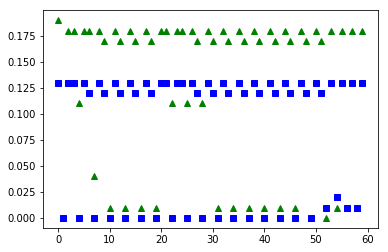

In [45]:
# we want to do a comparison in training speed



x_axis = []
y_axis1 = []
y_axis2 = []
curr_num = 0
for i in range(len(union_)):
    if -1 in union_[i]:
        continue
    else:
        x_axis.append(curr_num)
        y_axis1.append(union_[i][1])
        y_axis2.append(union_[i][3])
        curr_num += 1
        
plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
plt.show()



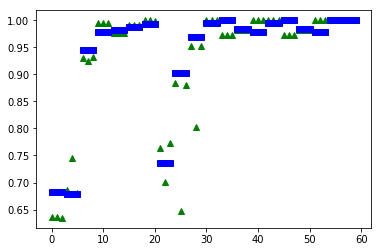

In [46]:
# we want to do a comparison in evaluation accuracy


x_axis = []
y_axis1 = []
y_axis2 = []
curr_num = 0
for i in range(len(union_)):
    if -1 in union_[i]:
        continue
    else:
        x_axis.append(curr_num)
        y_axis1.append(union_[i][0])
        y_axis2.append(union_[i][2])
        curr_num += 1
        
plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
plt.show()

In [47]:
#Comparison for only non random rows

def create_union_nonrandom(stats_arr, stats_arr_rep, row_names, row_names_rep):

    union_1 = np.zeros(shape = (len(row_names),4 ))

    print(len(row_names))
    print(len(row_names_rep))

    index = 0
    new_row_names = []
    for idx,row_name in enumerate(row_names):
        if ("t=" in row_name) or ("s=" in row_name):
            union_1[index,0] = stats_arr[idx][0]
            union_1[index,1] = stats_arr[idx][1]
            new_row_names.append(row_name)
            if row_name not in row_names_rep:
                union_1[index, 2] = -1
                union_1[index, 3] = -1
            else:
                corresponding_idx = row_names_rep.index(row_name)
                union_1[index,2] = stats_arr_rep[corresponding_idx][0]
                union_1[index,3] = stats_arr_rep[corresponding_idx][1]
            index += 1

    print(union_1)
    print(union_1.shape)
    return union_1

union_1 = create_union_nonrandom(b_stats_arr_rep, c_stats_arr_rep, b_row_names, c_row_names)




60
60
[[0.63549161 0.19       0.68153477 0.13      ]
 [0.63549161 0.         0.68153477 0.        ]
 [0.63453237 0.18       0.68153477 0.13      ]
 [0.68633094 0.18       0.67865707 0.13      ]
 [0.74484412 0.11       0.67865707 0.        ]
 [0.68105516 0.18       0.67865707 0.13      ]
 [0.93045564 0.18       0.94580336 0.12      ]
 [0.92374101 0.04       0.94580336 0.        ]
 [0.93141487 0.18       0.94580336 0.13      ]
 [1.         0.01       1.         0.02      ]
 [1.         0.18       1.         0.13      ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.   

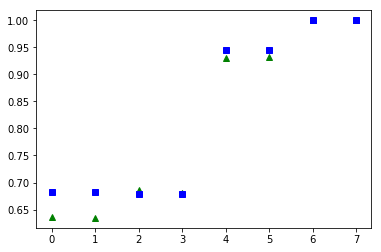

In [48]:
# we want to do a comparison in evaluation accuracy


x_axis = []
y_axis1 = []
y_axis2 = []
curr_num = 0
for i in range(len(union_1)):
    if -1 in union_1[i]:
        continue
    elif 0 in union_1[i]:
        continue
    else:
        x_axis.append(curr_num)
        y_axis1.append(union_1[i][0])
        y_axis2.append(union_1[i][2])
        curr_num += 1
        
plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
plt.show()

In [50]:

union_formatted = union_[1:, :]
avg_speed_original = sum(union_formatted[:, 1]) / len(union_formatted[:,1])
avg_speed_new = sum(union_formatted[:, 3]) / len(union_formatted[:,3])

print("avg time for b&w pipeline", round(avg_speed_original,3), "seconds")
print("avg time for color pipeline", round(avg_speed_new,3), "seconds")
print("Color pipeline is", round(avg_speed_original / avg_speed_new,3), "times faster")
avg_accuracy_original = sum(union_formatted[:,0]) / len(union_formatted[:,0])
avg_accuracy_new = sum(union_formatted[:,2]) / len(union_formatted[:,2])
print("avg accuracy for b&w pipeline", round(avg_accuracy_original,3), "%")
print("avg accuracy for color pipeline", round(avg_accuracy_new,3), "%")
print("avg accuracy for color is ", round(avg_accuracy_original - avg_accuracy_new,3),"worse than original (Note if negative, it means it is better!)")

union_formatted2 = union_1[1:12,:]
avg_accuracy_original_ = sum(union_formatted2[:,0]) / len(union_formatted2[:,0])
avg_accuracy_new_ = sum(union_formatted2[:,2]) / len(union_formatted2[:,2])
print("avg accuracy for non random columns of b&w pipeline", round(avg_accuracy_original_,3), "%")
print("avg accuracy for non random columns of color pipeline", round(avg_accuracy_new_,3), "%")
print("avg accuracy for color is ", round(avg_accuracy_original_ - avg_accuracy_new_,3),"worse than b&w (Note if negative, it means it is better!)")



avg time for b&w pipeline 0.124 seconds
avg time for color pipeline 0.082 seconds
Color pipeline is 1.509 times faster
avg accuracy for b&w pipeline 0.935 %
avg accuracy for color pipeline 0.943 %
avg accuracy for color is  -0.008 worse than original (Note if negative, it means it is better!)
avg accuracy for non random columns of b&w pipeline 0.743 %
avg accuracy for non random columns of color pipeline 0.749 %
avg accuracy for color is  -0.006 worse than b&w (Note if negative, it means it is better!)


In [35]:
a = [1,2,3,4,5]
print(a[1:3])

[2, 3]
